<a href="https://colab.research.google.com/github/kywch/geo-colab/blob/master/TreePedia_Step1_point_sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This function will parse throigh the street network of provided city and     clean all highways and create points every mini_dist meters (or as specified) along the linestrings 

Required modules: Fiona and Shapely

parameters:
* inshp: the input linear shapefile, must be in WGS84 projection, ESPG: 4326
* output: the result point feature class
* mini_dist: the minimum distance between two created point

Source: https://github.com/mittrees/Treepedia_Public/blob/master/Treepedia/createPoints.py, last modified by Xiaojiang Li, MIT Senseable City Lab


OSM examples: https://github.com/gboeing/osmnx-examples/tree/master/notebooks


In [1]:
!apt install python-rtree=0.8.3+ds-1
!pip install geopandas==0.7.0
!pip install osmnx==0.13.0 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-rtree is already the newest version (0.8.3+ds-1).
0 upgraded, 0 newly installed, 0 to remove and 22 not upgraded.


In [31]:
import os,os.path
from glob import glob
from shutil import copyfile

import fiona
from shapely.geometry import shape,mapping
from shapely.ops import transform
from functools import partial
import pyproj
from fiona.crs import from_epsg

import osmnx as ox
import matplotlib.pyplot as plt

import pandas as pd
import geopandas as gpd

from numpy import arange

# optimization-related
import time

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
!ls drive/My\ Drive/StreetPsych

In [57]:
#place_name = "Chicago, Illinois, USA"
place_name = "Hyde Park, Chicago, Illinois, USA"
graph = ox.graph_from_place(place_name, network_type='walk')

In [23]:
location = 'HydePark' # 'Chicago'

#ox.save_graph_shapefile(graph, filepath='drive/My Drive/StreetPsych/Chicago')
ox.save_graph_shapefile(graph, filepath='drive/My Drive/StreetPsych/HydePark')

In [28]:
files = glob("drive/My Drive/StreetPsych/Chicago/*")
print(files)

['drive/My Drive/StreetPsych/Chicago/nodes.shp', 'drive/My Drive/StreetPsych/Chicago/nodes.shx', 'drive/My Drive/StreetPsych/Chicago/nodes.dbf', 'drive/My Drive/StreetPsych/Chicago/nodes.cpg', 'drive/My Drive/StreetPsych/Chicago/nodes.prj', 'drive/My Drive/StreetPsych/Chicago/edges.shp', 'drive/My Drive/StreetPsych/Chicago/edges.shx', 'drive/My Drive/StreetPsych/Chicago/edges.dbf', 'drive/My Drive/StreetPsych/Chicago/edges.cpg', 'drive/My Drive/StreetPsych/Chicago/edges.prj']


In [29]:
if not os.path.exists('source'):
  os.mkdir('source')

In [32]:
# copy these files from Google Drive to colab disk
for f in files:
  print(f)
  copyfile(f, 'source/' + os.path.basename(f))

drive/My Drive/StreetPsych/Chicago/nodes.shp
drive/My Drive/StreetPsych/Chicago/nodes.shx
drive/My Drive/StreetPsych/Chicago/nodes.dbf
drive/My Drive/StreetPsych/Chicago/nodes.cpg
drive/My Drive/StreetPsych/Chicago/nodes.prj
drive/My Drive/StreetPsych/Chicago/edges.shp
drive/My Drive/StreetPsych/Chicago/edges.shx
drive/My Drive/StreetPsych/Chicago/edges.dbf
drive/My Drive/StreetPsych/Chicago/edges.cpg
drive/My Drive/StreetPsych/Chicago/edges.prj


In [33]:
!ls source

edges.cpg  edges.prj  edges.shx  nodes.dbf  nodes.shp
edges.dbf  edges.shp  nodes.cpg  nodes.prj  nodes.shx


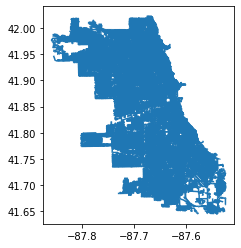

In [34]:
osm_map = gpd.read_file('source/edges.shp')
osm_map.plot()

In [35]:
osm_map.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 187524 entries, 0 to 187523
Data columns (total 22 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   u         187524 non-null  int64   
 1   v         187524 non-null  int64   
 2   key       187524 non-null  int64   
 3   osmid     187524 non-null  object  
 4   highway   187524 non-null  object  
 5   service   49217 non-null   object  
 6   oneway    187524 non-null  int64   
 7   length    187524 non-null  float64 
 8   from      187524 non-null  int64   
 9   to        187524 non-null  int64   
 10  name      91476 non-null   object  
 11  lanes     11384 non-null   object  
 12  ref       2589 non-null    object  
 13  access    1954 non-null    object  
 14  tunnel    1430 non-null    object  
 15  bridge    787 non-null     object  
 16  maxspeed  2278 non-null    object  
 17  landuse   1 non-null       object  
 18  junction  26 non-null      object  
 19  width     26 no

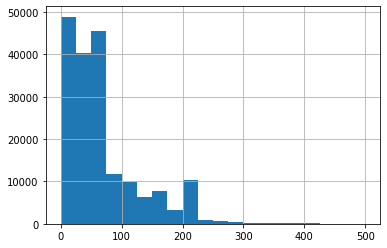

In [43]:
#osm_map_flt['osmid']
#osm_map_flt['geometry'].iloc[0]
valid = (osm_map['length'] < 500)
osm_map.loc[valid, 'length'].hist(bins=20)

In [44]:
len_4326 = []
len_meter = []
num_coords = []

for index, row in osm_map.iterrows():
  line = row['geometry']
  num_coords.append(len(line.coords))
  len_4326.append(line.length)
  len_meter.append(row['length']) # in meters

In [45]:
quick_df = pd.DataFrame({'num_coords': num_coords, 'len_4326':len_4326, 'len_meter':len_meter})
quick_df['ratio'] = quick_df['len_4326'] / quick_df['len_meter']

In [47]:
quick_df.describe()

,num_coords,len_4326,len_meter,ratio
count,187524.000000,1.875240e+05,187524.000000,187524.000000
mean,2.658470,7.135968e-04,68.912262,0.000011
std,2.460472,7.002653e-04,68.997867,0.000001
min,2.000000,2.000000e-07,0.017000,0.000009
25%,2.000000,2.502405e-04,23.495750,0.000009
50%,2.000000,5.518496e-04,50.316000,0.000011
75%,2.000000,9.035559e-04,86.859000,0.000012
max,216.000000,2.471371e-02,2572.364000,0.000012


In [50]:
def sample_points(shapefile, sample_dist, visualize=True):

  # load the shape file: should be edges
  osm_map = gpd.read_file(shapefile)

  # filter the load
  flt_list = ['trunk_link','tertiary','motorway','motorway_link','steps', None, ' ',
              'pedestrian','primary', 'primary_link','footway','tertiary_link', 'trunk',
              'secondary','secondary_link','tertiary_link','bridleway','service']

  # clean the original street maps by removing highways, if it the street map not from Open street data, users'd better to clean the data themselve
  flt_idx = osm_map['highway'].apply(lambda x: x not in flt_list)
  osm_map_flt = osm_map[flt_idx]
  print('Filtering done: all rows', len(flt_idx), ', after: ', sum(flt_idx))

  # get bearing for each road
  #osm_map_flt['bearing'] = osm_map_flt['geometry'].apply(lambda line: round(ox.bearing.get_bearing(line.coords[0], line.coords[1])))

  # get the minimum distance in EPSG:4326
  ratio = []
  for index, row in osm_map_flt.iterrows():
    line = row['geometry']
    ratio.append(line.length / row['length'])
  sample_dist_4326 = sample_dist * sum(ratio) / len(ratio)

  # sampling the points
  count = 0
  results = []
  for index, row in osm_map_flt.iterrows():
    line = row['geometry']
    results.extend([
      line.interpolate(dist) #[line.interpolate(dist), row['osmid']]
      for dist in arange(sample_dist_4326/2, line.length, sample_dist_4326)
    ])

    count += 1
    if (count % 1000 == 0):
      print('Processed: ', count, ', points: ', len(results))

  return results


In [54]:
points = sample_points('source/edges.shp', 20)

Filtering done: all rows 187524 , after:  64224
Processed:  1000 , points:  3452
Processed:  2000 , points:  6673
Processed:  3000 , points:  9962
Processed:  4000 , points:  13131
Processed:  5000 , points:  16176
Processed:  6000 , points:  19439
Processed:  7000 , points:  23739
Processed:  8000 , points:  28240
Processed:  9000 , points:  32381
Processed:  10000 , points:  36334
Processed:  11000 , points:  39926
Processed:  12000 , points:  43664
Processed:  13000 , points:  48089
Processed:  14000 , points:  52367
Processed:  15000 , points:  55956
Processed:  16000 , points:  59518
Processed:  17000 , points:  63365
Processed:  18000 , points:  67075
Processed:  19000 , points:  71465
Processed:  20000 , points:  75231
Processed:  21000 , points:  79043
Processed:  22000 , points:  83257
Processed:  23000 , points:  87200
Processed:  24000 , points:  90909
Processed:  25000 , points:  95080
Processed:  26000 , points:  99206
Processed:  27000 , points:  102887
Processed:  28000 

In [55]:
picked_gdf = gpd.GeoSeries(points)
picked_gdf.head()

0    POINT (-87.72991 41.77189)
1    POINT (-87.72992 41.77210)
2    POINT (-87.72992 41.77231)
3    POINT (-87.72993 41.77252)
4    POINT (-87.72993 41.77273)
dtype: geometry

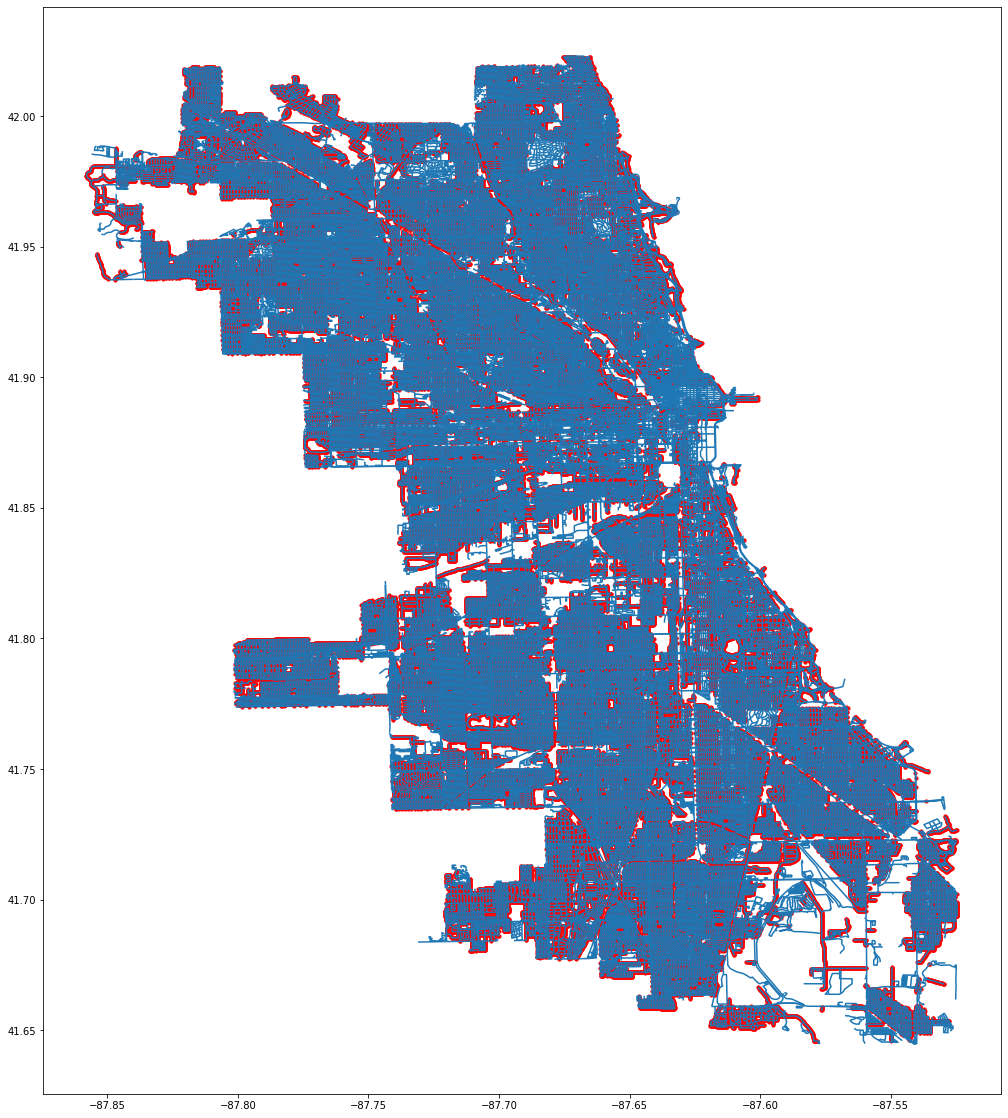

In [56]:
fig, ax = plt.subplots(figsize=(20,20))

osm_map.plot(ax=ax)
picked_gdf.plot(ax=ax, color='red', markersize=10)